![title](images/header.png)

# Ve - Supervised Classification of eSBAE with CAFI data - multiple models
-------
This notebook performs a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler
#!pip install xgboost

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


## Parameters

In [3]:
# country area (ha) incomment the line with your country of interest
#GAB
study_area = 26287600
#DRC
#study_area = 232798200
#COG
#study_area = 34402400
#CMR
#study_area = 46497000
#EQG
#study_area = 2685800
#CAR
#study_area = 62009300

### 1 - data preparation
#### 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5e - with all the eSBAE columns

In [4]:
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

,geometry,point_id,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,TropBiome,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010,lon,lat,ISO,sampling,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,stable_prob_cafi1520,kmeans_chg,kmeans_def,kmeans_deg,plotid,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,chg_prob,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFtype,Ref_Ftype,Commentaires,collection,interpreted,Ref_LCover,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF
0,POINT (10.778096601235843 -1.197510356812697),76053.0,51,31,-1.000,0.000000,0.000000,2021.581,0.506586,3182.462366,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,9724.413978,262.521420,9179.0,10000.0,0.750638,21.374971,60.963004,-83.864098,18103,1,246.234512,18319,1,2.409739,0,0,4.430581,0.000,0.000000,194,1.0,74.0,3.0,22.0,63.0,284.601074,10,10,2,2,2,2.0,2,0,0,0.0,91,36.0,34,21,1,1,1,1,1,1.0,1.0,0.0,0.0,10.0,10.0,AT0102,Atlantic Equatorial Coastal Forests,2.0,AT0102. Atlantic Equatorial coastal forests,1.0,1,5,83,436,10.778097,-1.197510,GAB,systematic,NaN,NaN,NaN,NaN,NaN,0.013333,0.016667,0.024000,0.995333,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
1,POINT (11.384048972224505 -0.907979628551144),100573.0,44,29,2019.370,-661.408752,-1.861164,2019.370,0.270975,10382.470690,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,9312.490230,1345.663255,3868.0,10000.0,-42.474946,32.004523,85.594657,-172.453678,18343,1,-402.519574,18279,1,-4.061289,18279,1,-3.962060,0.000,0.000000,266,1.0,74.0,28.0,8.0,70.0,486.137970,10,10,2,2,2,2.0,2,0,0,0.0,90,33.0,32,9,1,1,1,1,1,1.0,1.0,0.0,0.0,10.0,10.0,AT0102,Atlantic Equatorial Coastal Forests,2.0,AT0102. Atlantic Equatorial coastal forests,1.0,1,5,86,229,11.384049,-0.907980,GAB,systematic,NaN,NaN,NaN,NaN,NaN,0.057333,0.032000,0.103333,0.976000,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
2,POINT (12.27427314961694 1.7087971459051252),76354.0,40,31,2016.022,359.061890,0.440676,2022.241,0.203409,3427.817204,9491.010753,451.618955,7995.0,10000.0,9491.010753

In [75]:
# output file of eSBAE points with model classification
out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_1522_model.csv'

## End of parameters

In [6]:
len(ceo_esbae_1522)

222878

In [7]:
ceo_esbae_1522['kmeans_chg'].value_counts(dropna=False)

kmeans_chg
1    143313
2     68205
3     11360
Name: count, dtype: int64

In [8]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Type_1522,,,,
Def,NaN,11.0,63.0,74
Deg,5.0,26.0,182.0,213
NF,65.0,725.0,576.0,1366
Stable,2117.0,3169.0,1434.0,6720
Total,2187.0,3931.0,2255.0,8373


In [9]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,2.0,21.0,23
Def2017,NaN,3.0,11.0,14
Def2018,NaN,NaN,8.0,8
Def2019,NaN,NaN,2.0,2
Def2020,NaN,1.0,6.0,7
Def2021,NaN,1.0,6.0,7
Def2022,NaN,4.0,9.0,13
Deg2016,NaN,3.0,15.0,18
Deg2017,NaN,1.0,19.0,20


In [10]:
all_ceo_cols = ceo_esbae_1522.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['geometry', 'point_id', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 

In [11]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
    #'bfast_change_date', 'bfast_magnitude', 'bfast_means', 
    'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
    'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
    'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
    'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
    'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
    'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
    'ccdc_change_date', 'ccdc_magnitude', 'aspect', 
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
    'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
    #'gfc_gain', 
    'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
    'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub',
    'CAFI_LC_2015', 'Frag_2015', 'Treecov_2015', 'Biomass_2010']

In [12]:
df = ceo_esbae_1522

### 1.2 where/what are NAs
evaluate and replace no data values

In [13]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_p

In [14]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [15]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [16]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_p

In [17]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    214505
1.0      6720
0.0      1653
Name: count, dtype: int64

In [18]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [19]:
interpreted = gdf[gdf['interpreted'] == 1]

### 1.3 Run classifications on entire eSBAE dataset trained with CEO interpreted data

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [20]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.8068792547474024


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

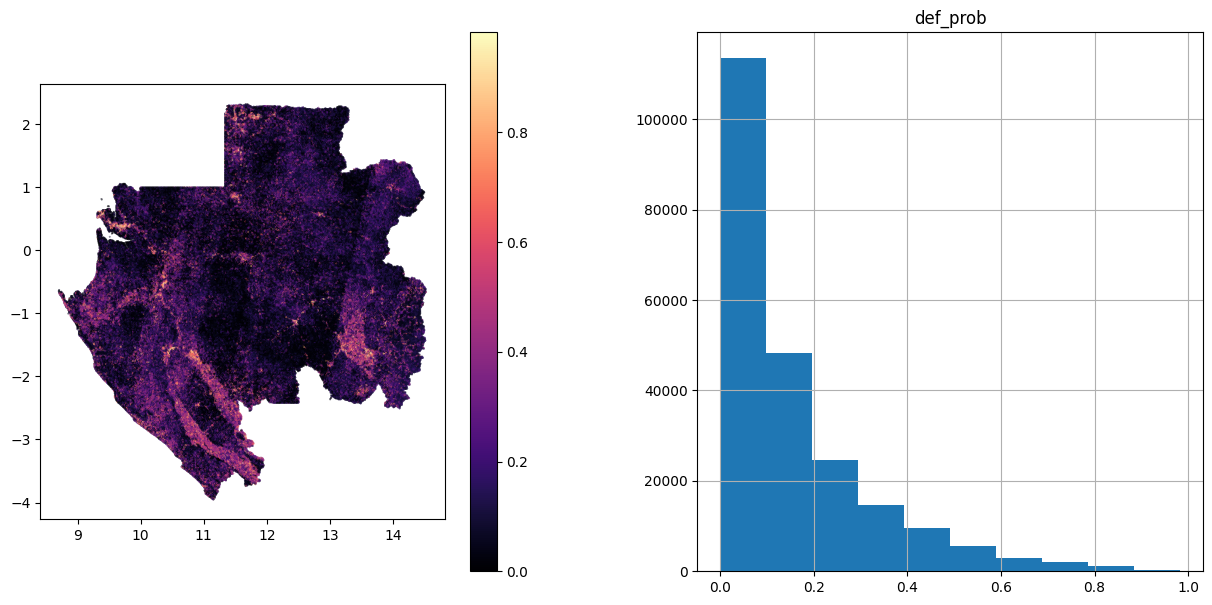

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [22]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.8262271587244715


array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

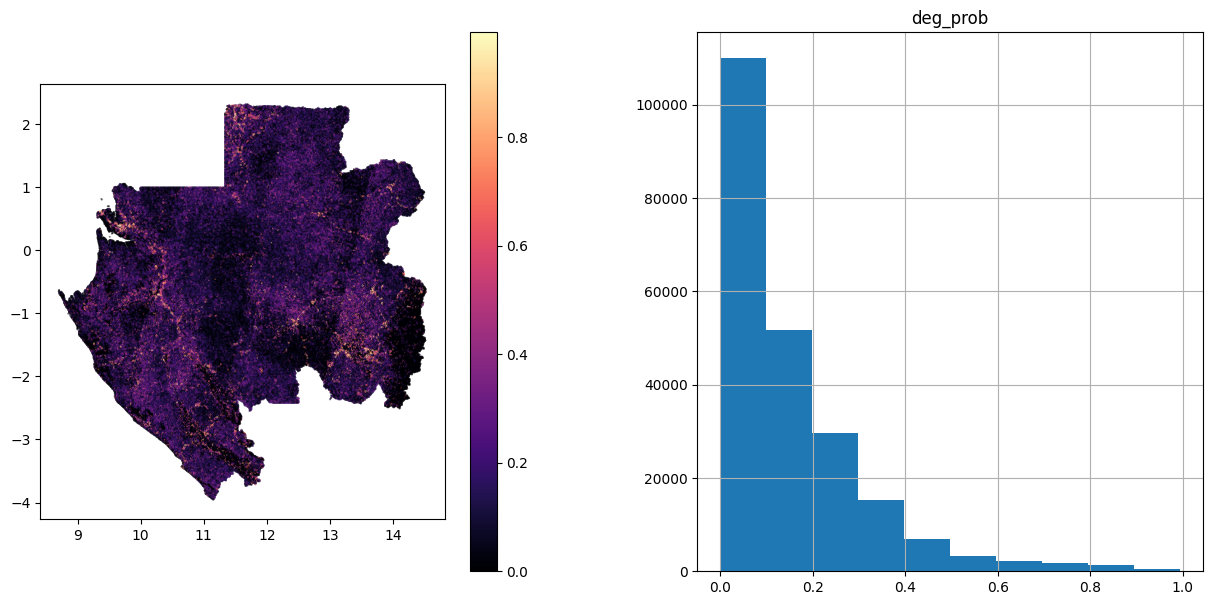

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [24]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.8853457542099605


array([<Axes: title={'center': 'stable_prob'}>], dtype=object)

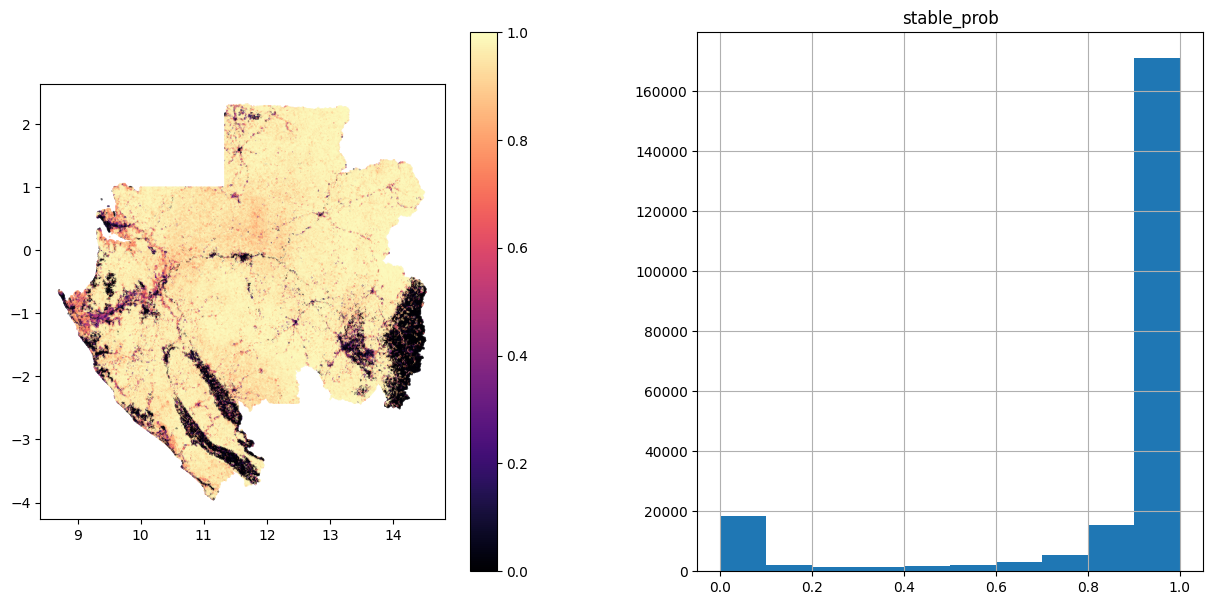

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [26]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.8936862319295759


array([<Axes: title={'center': 'nf_prob'}>], dtype=object)

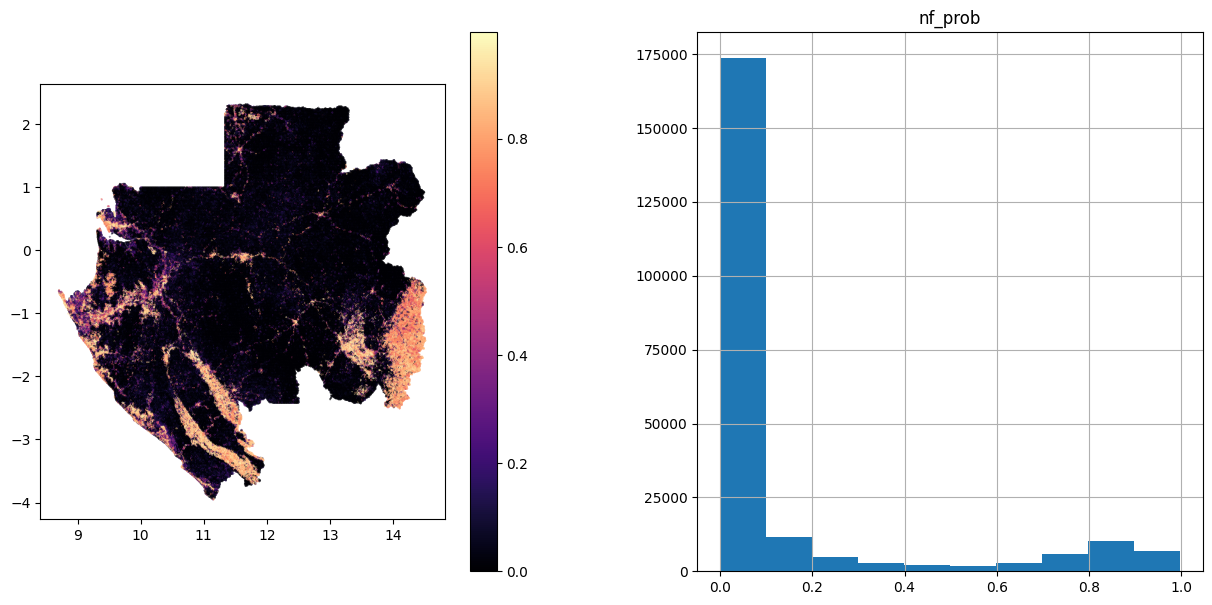

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [28]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

##### looking at validated data in comparison to model

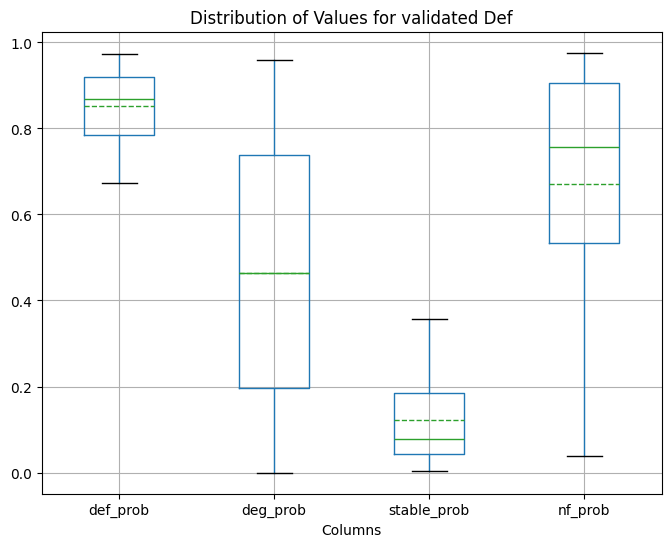

        def_prob   deg_prob  stable_prob    nf_prob
count  74.000000  74.000000    74.000000  74.000000
mean    0.852901   0.463541     0.121541   0.670766
std     0.083237   0.299390     0.100650   0.290002
min     0.674000   0.000000     0.003333   0.039333
25%     0.785167   0.197667     0.043667   0.533000
50%     0.867000   0.464667     0.078000   0.757667
75%     0.919167   0.739000     0.186000   0.905500
max     0.972667   0.958667     0.357333   0.976000


In [29]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

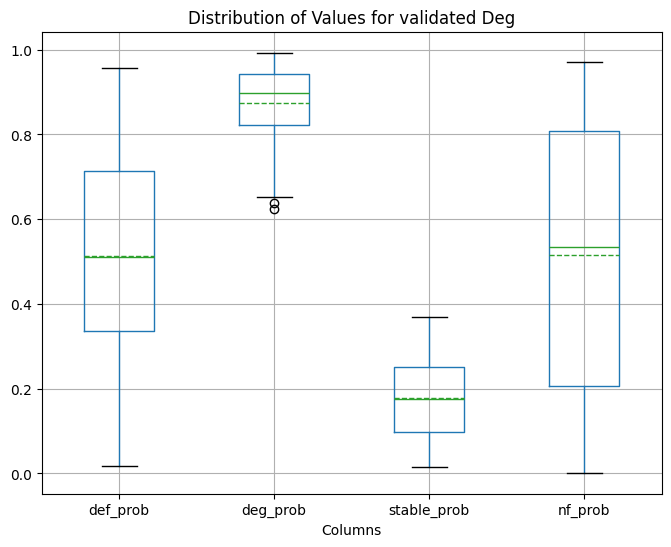

         def_prob    deg_prob  stable_prob     nf_prob
count  213.000000  213.000000   213.000000  213.000000
mean     0.512958    0.874510     0.178485    0.516125
std      0.250188    0.090592     0.091245    0.313857
min      0.017333    0.624000     0.014667    0.002000
25%      0.336667    0.823333     0.097333    0.207333
50%      0.511333    0.897333     0.176000    0.534667
75%      0.713333    0.943333     0.252000    0.808000
max      0.956000    0.993333     0.370000    0.970667


In [30]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

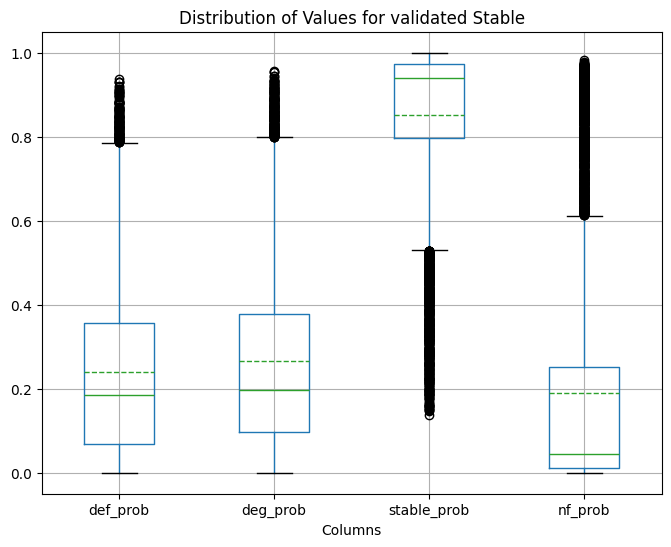

          def_prob     deg_prob  stable_prob      nf_prob
count  6720.000000  6720.000000  6720.000000  6720.000000
mean      0.238394     0.265702     0.851547     0.188964
std       0.207189     0.220621     0.187280     0.272929
min       0.000000     0.000000     0.136000     0.000000
25%       0.068000     0.096667     0.796000     0.011333
50%       0.184000     0.196000     0.938667     0.045333
75%       0.355333     0.377333     0.974000     0.251333
max       0.936667     0.955333     1.000000     0.982667


In [31]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

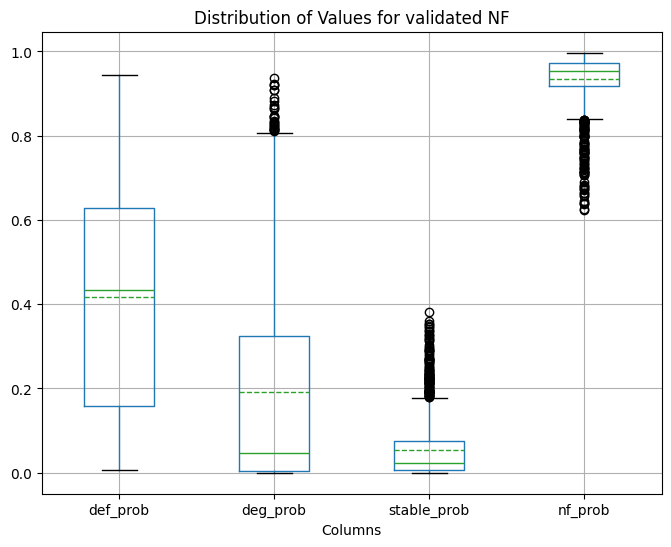

          def_prob     deg_prob  stable_prob      nf_prob
count  1366.000000  1366.000000  1366.000000  1366.000000
mean      0.417202     0.190414     0.054042     0.934432
std       0.259695     0.250645     0.071187     0.060612
min       0.005333     0.000000     0.000000     0.622667
25%       0.158667     0.002667     0.006000     0.918667
50%       0.433667     0.045667     0.022000     0.953333
75%       0.629333     0.324667     0.074667     0.972000
max       0.944000     0.938000     0.382000     0.997333


In [32]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [33]:
threshold = 0.8

In [34]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [35]:
gdf['max_prob'] = gdf[['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']].idxmax(axis=1)

# Replace the string in a specific column ('column_name')
gdf['max_prob'] = gdf['max_prob'].str.replace('_prob', '')
gdf['max_prob'] = gdf['max_prob'].replace({'def': 'Def', 'deg': 'Deg','stable':'Stable','nf':'NF'}, regex=True)

gdf['max_prob'].value_counts(dropna=False)

max_prob
Stable    194827
NF         24824
Deg         2608
Def          619
Name: count, dtype: int64

In [36]:
# Calculate the proportions and areas based on max probability classification
prob_counts = gdf['max_prob'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

          Value Counts  Percentage of Total Rows     area
max_prob                                                 
Stable          194827                        87 22979093
NF               24824                        11  2927895
Deg               2608                         1   307604
Def                619                         0    73009


In [37]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in the Gabon case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'Stable'
    elif row['sim_def'] >= 1:
        return 'Def'
    elif row['sim_deg'] >= 1:
        return 'Deg'
    else:
        return 'NF'

# Apply the function to create a new 'classification' column
gdf['prob_class'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['prob_class'].value_counts(dropna=False)

prob_class
Stable    186612
NF         33518
Def         1394
Deg         1354
Name: count, dtype: int64

In [38]:
# Calculate the proportions and areas based on decision tree classification
prob_counts = gdf['prob_class'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

            Value Counts  Percentage of Total Rows     area
prob_class                                                 
Stable            186612                        84 22010165
NF                 33518                        15  3953319
Def                 1394                         1   164417
Deg                 1354                         1   159699


In [39]:
# Group by the selected columns and count occurrences
result_df = gdf.groupby(['prob_class', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

   prob_class  Defall  Degall  Stable  NF  count
0         Def       0       0       0   1    107
1         Def       0       0       1   0    114
2         Def       0       1       0   0     31
3         Def       1       0       0   0     51
4         Deg       0       0       0   1     24
5         Deg       0       0       1   0    168
6         Deg       0       1       0   0    139
7         Deg       1       0       0   0      2
8          NF       0       0       0   1   1235
9          NF       0       0       1   0   1425
10         NF       0       1       0   0     43
11         NF       1       0       0   0     21
12     Stable       0       0       1   0   5013


In [40]:
# Create a new column 'Count' based on the conditions to determine if points are in multiple classes
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

col_0   Count
Count        
0       18171
1      203083
2        1301
3         323


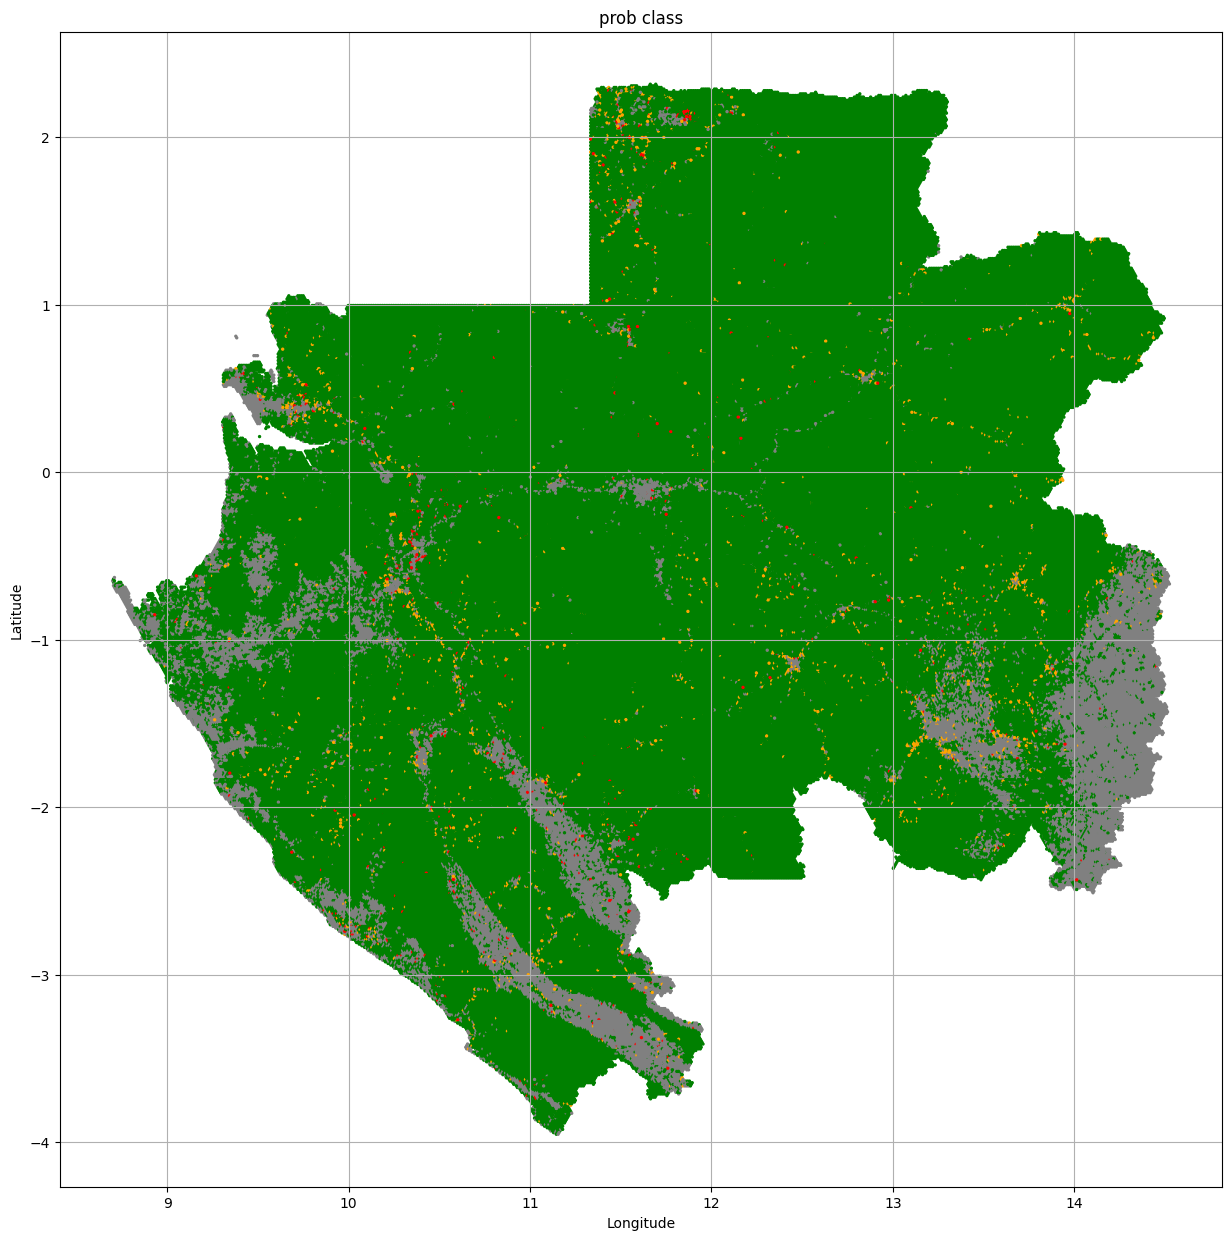

In [41]:
# plot point classes
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['max_prob'].map(category_colors), s=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('prob class')
plt.grid()
plt.show()

#### Supervised classifications

In [42]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_1522']

In [43]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

{'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_p

In [44]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

array(['Def', 'Deg', 'NF', 'Stable'], dtype=object)

In [45]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

{'Def': 29.901785714285715,
 'Deg': 9.251381215469614,
 'NF': 1.5112815884476534,
 'Stable': 0.3128152437885298}

In [47]:
#Balanced random forest classifier
#clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.07      0.56      0.12        18
         Deg       0.08      0.56      0.14        32
          NF       0.77      0.72      0.74       258
      Stable       0.98      0.77      0.86      1367

    accuracy                           0.76      1675
   macro avg       0.48      0.65      0.47      1675
weighted avg       0.92      0.76      0.82      1675



In [48]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7558208955223881


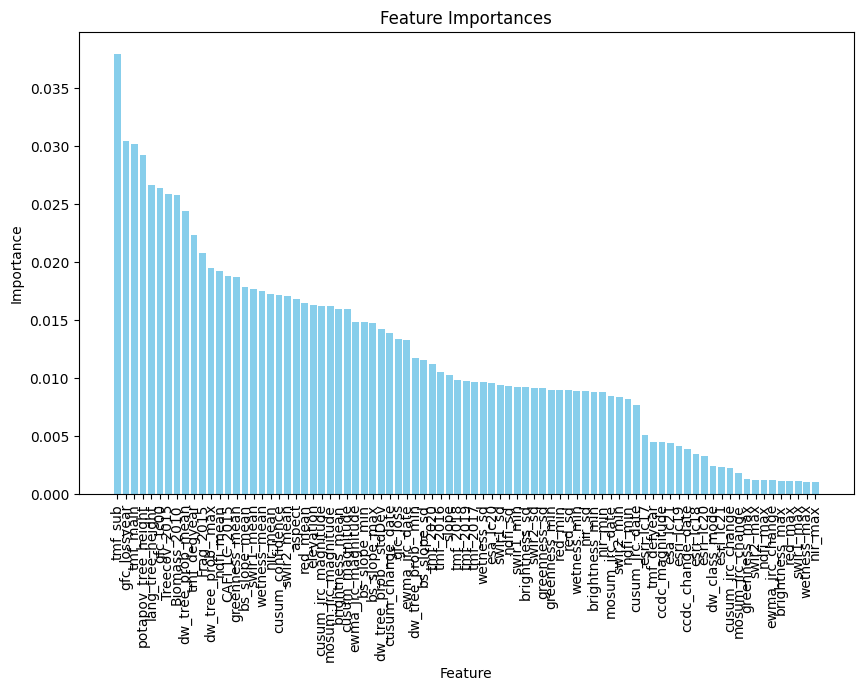

In [49]:
# Get feature importances
importances = clf.feature_importances_

# Get column names
column_names = X_train.columns

# Sort feature importances in descending order
indices = (-importances).argsort()

# Plot feature importances with column names
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), column_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [50]:
# Calculate the proportions of classified points
value_counts = gdf['balRF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

            Value Counts  Percentage of Total Rows     area
balRF_pred                                                 
Stable            192841                        87 22744852
NF                 20739                         9  2446085
Deg                 5584                         3   658611
Def                 3714                         2   438052


In [51]:
# Create an instance of the random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=42, oob_score=True) # too low
clf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=class_weight_dict)
# Fit the classifier to your training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Make predictions on new data
gdf['RF_pred'] = clf.predict(gdf[eSBAE_cols])

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.00      0.00      0.00        18
         Deg       1.00      0.03      0.06        32
          NF       0.84      0.77      0.80       258
      Stable       0.93      0.98      0.96      1367

    accuracy                           0.92      1675
   macro avg       0.69      0.44      0.45      1675
weighted avg       0.91      0.92      0.90      1675



In [52]:
# Calculate the proportions
value_counts = gdf['RF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

         Value Counts  Percentage of Total Rows     area
RF_pred                                                 
Stable         202292                        91 23859561
NF              20326                         9  2397373
Deg               202                         0    23825
Def                58                         0     6841


In [53]:
#CART Model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict on the Testing Dataset
y_pred = model.predict(X_test)
gdf['CART_pred'] = model.predict(gdf[eSBAE_cols])
# Step 4: Evaluate the Model (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

Accuracy on the test set: 0.8513432835820895
              precision    recall  f1-score   support

         Def       0.07      0.06      0.06        18
         Deg       0.11      0.19      0.13        32
          NF       0.67      0.71      0.69       258
      Stable       0.93      0.90      0.92      1367

    accuracy                           0.85      1675
   macro avg       0.44      0.46      0.45      1675
weighted avg       0.86      0.85      0.86      1675



In [54]:
# Calculate the proportions
value_counts = gdf['CART_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

           Value Counts  Percentage of Total Rows     area
CART_pred                                                 
Stable           198535                        89 23416437
NF                21876                        10  2580190
Deg                1885                         1   222328
Def                 582                         0    68645


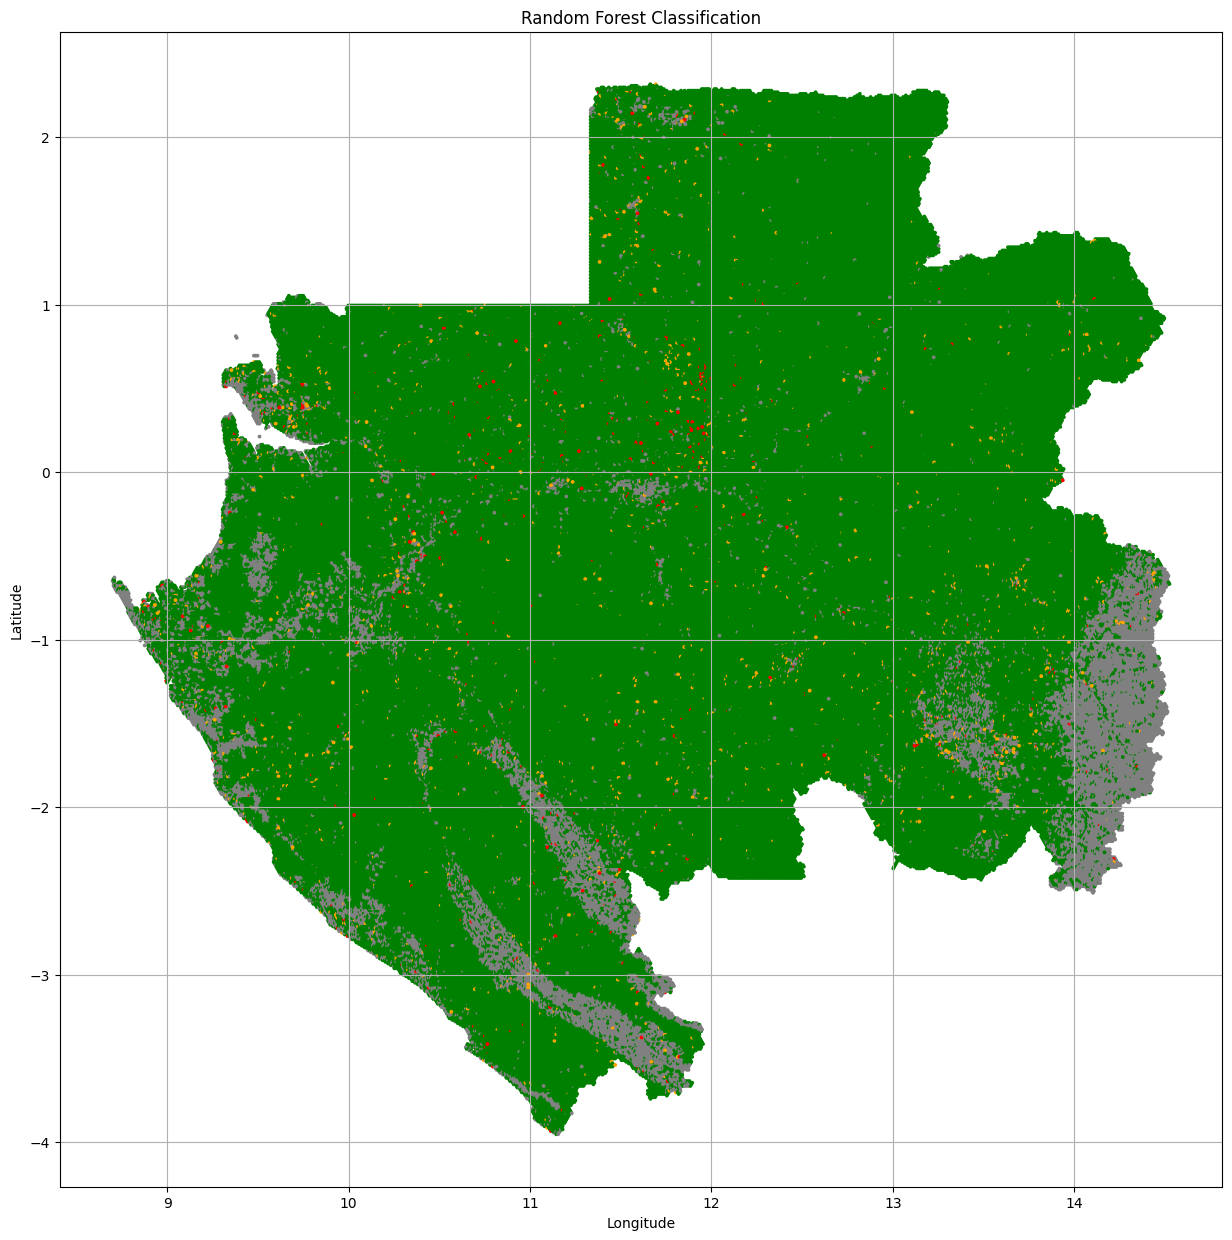

In [55]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['CART_pred'].map(category_colors), s=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

#### add years to all points

In [58]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)
gdf['ccdc_change_year'] = np.floor(gdf['ccdc_change_date']).astype(int)
gdf['bfast_change_year'] = np.floor(gdf['bfast_change_date']).astype(int)

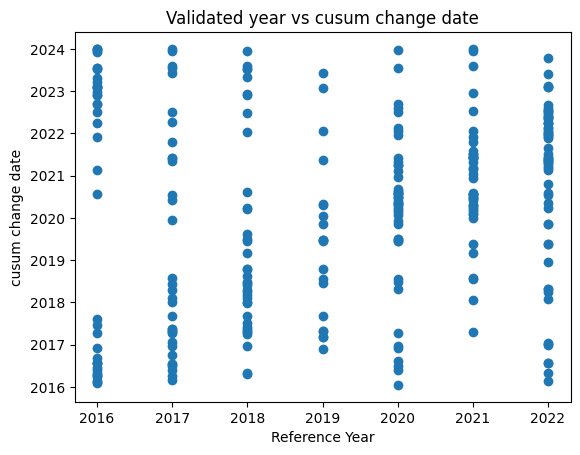

In [59]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

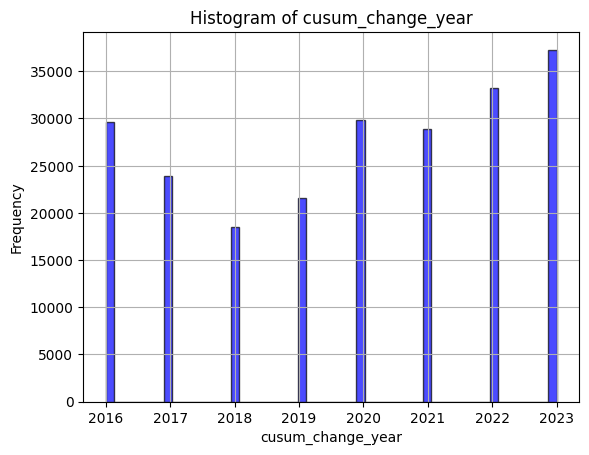

In [60]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

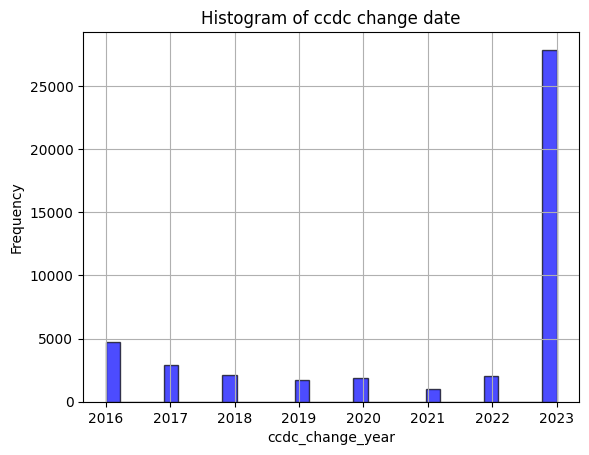

In [61]:
# plot histogram of ccfc change
gdf_ccdc = gdf[gdf['ccdc_change_year']>0]
plt.hist(gdf_ccdc['ccdc_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ccdc change date')
plt.xlabel('ccdc_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

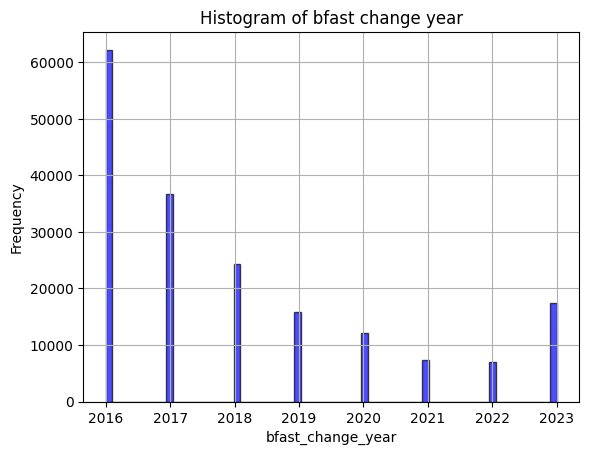

In [62]:
# plot histogram of cusum change
gdf_bfast = gdf[gdf['bfast_change_year']>0]
plt.hist(gdf_bfast['bfast_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of bfast change year')
plt.xlabel('bfast_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [63]:
#choose which model to use
# 'max_prob' 'prob_class' RF_pred balRF_pred CART_pred
model = 'CART_pred'

In [64]:
# create hybrid column taking the class from the model you choose and combining with cusum date
def y(x):
  if x[model] == 'Def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x[model] == 'Def' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Deg' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Def' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Deg' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Stable' : return 'Stable'
  elif x[model] == 'NF' : return 'NF'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

Sim_Ref_Change_Year_1522
Def2016        72
Def2017        52
Def2018        55
Def2019        60
Def2020        68
Def2021        90
Def2022        71
Deg2016       258
Deg2017       175
Deg2018       170
Deg2019       183
Deg2020       281
Deg2021       270
Deg2022       231
NF          21876
Stable     198966
Name: count, dtype: int64


In [65]:
#create hybrid column with values keeping interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf[model])
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])

In [66]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

Sim_CEO_Ref_Change_Type_1522
Stable    198572
NF         21861
Deg         1860
Def          585
Name: count, dtype: int64

In [67]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False).sort_index()

Sim_CEO_Ref_Change_Year_1522
Def2016        83
Def2017        60
Def2018        58
Def2019        56
Def2020        67
Def2021        85
Def2022        71
Deg2016       251
Deg2017       170
Deg2018       174
Deg2019       187
Deg2020       276
Deg2021       272
Deg2022       253
NF          21861
Stable     198954
Name: count, dtype: int64

In [68]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count",margins=True,
                             margins_name='Total')

interpreted,0,1,Total
Sim_CEO_Ref_Change_Year_1522,,,
Def2016,60,23,83
Def2017,46,14,60
Def2018,50,8,58
Def2019,54,2,56
Def2020,60,7,67
Def2021,78,7,85
Def2022,58,13,71
Deg2016,233,18,251
Deg2017,150,20,170


In [69]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Sim_CEO_Ref_Change_Type_1522,,,,
Def,114,230,241,585
Deg,380,492,988,1860
NF,4415,14250,3196,21861
Stable,138404,53233,6935,198572
Total,143313,68205,11360,222878


In [70]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Sim_CEO_Ref_Change_Year_1522,,,,
Def2016,9,24,50,83
Def2017,14,19,27,60
Def2018,12,21,25,58
Def2019,14,22,20,56
Def2020,15,32,20,67
Def2021,18,36,31,85
Def2022,16,27,28,71
Deg2016,49,61,141,251
Deg2017,44,45,81,170


In [71]:
#use stratum counts to calculate stats from CEO  points
pd.pivot_table(gdf,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,2,21,23
Def2017,NaN,3,11,14
Def2018,NaN,NaN,8,8
Def2019,NaN,NaN,2,2
Def2020,NaN,1,6,7
Def2021,NaN,1,6,7
Def2022,NaN,4,9,13
Deg2016,NaN,3,15,18
Deg2017,NaN,1,19,20


#### plot data

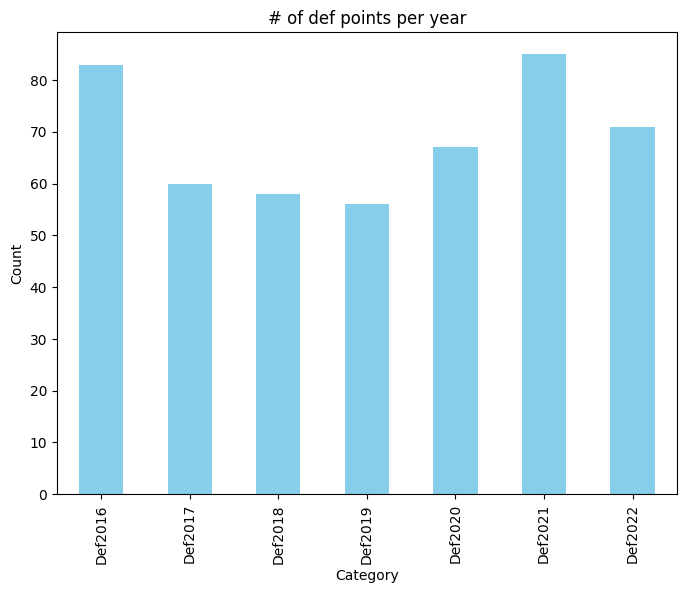

In [72]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

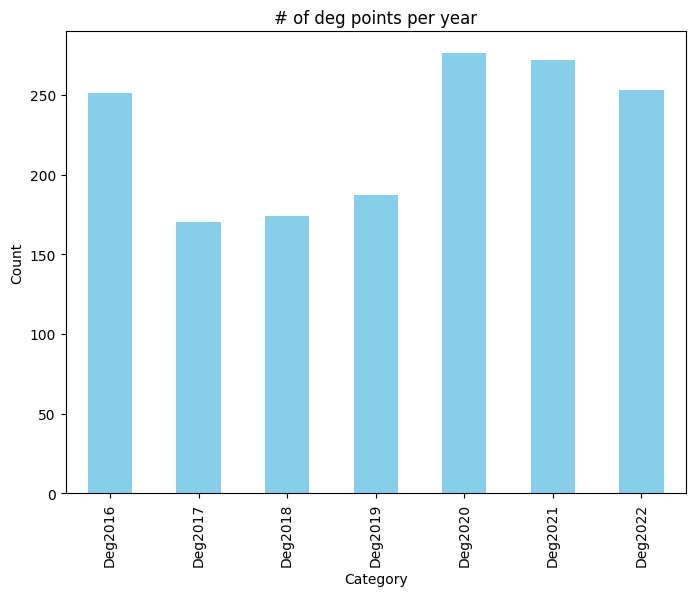

In [73]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [ ]:
gdf.to_csv(out_file,index=True)